In [1]:
# Import all modules
%matplotlib inline
import random
import pylab
import pickle as pkl
import numpy as np
import pandas as pd
from scipy.misc import imread, imresize
from lasagne import layers, updates
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score

script_root = '/home/faizy/workspace/project/project/scripts/'
data_root = '/home/faizy/workspace/project/project/datasets/'
model_root = '/home/faizy/workspace/project/project/models/'

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [2]:
# Load dataset
data = pd.read_csv(script_root + 'tester.txt', sep = ' ', header = None)

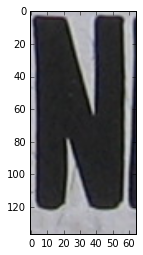

In [9]:
# Visualize dataset
from scipy.misc import imread as ims
i = random.randrange(0, data[0].count())
img = ims(data_root + 'English/' + data[0][i])
pylab.imshow(img)
pylab.show()

In [10]:
data[1].count()

12503

In [11]:
# Reshape images to 32x32
# Conversion to grayscale
data_x = np.zeros((data[0].count(), 1, 32, 32))
data_y = data[1].values

for idx, path in enumerate(data[0]):
    img = imread(data_root + 'English/' + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')

# Divide dataset to train and test
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [12]:
print "Train_x Shape: ", train1_x.shape, "\nTest_x Shape: ", test1_x.shape,"\nTrain_y Shape: ", train1_y.shape,"\nTest_y Shape: ", test1_y.shape

Train_x Shape:  (10002, 1, 32, 32) 
Test_x Shape:  (2501, 1, 32, 32) 
Train_y Shape:  (10002,) 
Test_y Shape:  (2501,)


In [13]:
# Normalize by MuSigma
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

In [14]:
# Setting X and Y
X = train1_x.astype('float32')
y = train1_y.astype('int32')

In [15]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv6', layers.Conv2DLayer),
        ('dropout6', layers.DropoutLayer),
        ('hidden7', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (3, 3), 
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (2, 2), 
    pool2_pool_size = (2, 2),
    dropout2_p = 0.3,
    conv6_num_filters = 128, conv6_filter_size = (7, 7),
    dropout6_p = 0.5,
    hidden7_num_units = 128,
    output_num_units = 62, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 500),
    batch_iterator_test = BatchIterator(batch_size = 500),

    update = updates.adam,

    use_label_encoder = True,
    regression = False,
    max_epochs = 100,
    verbose = 1,
)

In [16]:
# train nn
net.fit(X,y);

# Neural Network with 434622 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x30x30
  2  pool1     32x15x15
  3  dropout1  32x15x15
  4  conv2     64x14x14
  5  pool2     64x7x7
  6  dropout2  64x7x7
  7  conv6     128x1x1
  8  dropout6  128x1x1
  9  hidden7   128
 10  output    62

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       3.94166       3.96414      0.99433      0.06200  6.77s
      2       3.79292       3.89830      0.97297      0.08920  6.76s
      3       3.66678       3.73081      0.98284      0.16800  6.76s
      4       3.39505       3.39776      0.99920      0.23400  7.22s
      5       3.02925       3.01551      1.00456      0.31400  6.80s
      6       2.67716       2.64912      1.01058      0.38400  6.76s
      7       2.38456       2.32751      1.02451      0.43240  6.76s
      8       2.1

In [31]:
# Save model
f = open(model_root + 'recognizer_3.pkl', 'wb')
pkl.dump(net, f)
f.close()

In [17]:
# Load model
f = open(model_root + 'recognizer.pkl', 'rb')
net = pkl.load(f)
f.close()

In [18]:
# Test model
pred = net.predict(test1_x)

In [19]:
print classification_report(test1_y, pred)
print accuracy_score(test1_y, pred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        31
          1       0.81      0.57      0.67        23
          2       0.71      0.91      0.80        22
          3       0.60      0.67      0.63         9
          4       0.87      0.72      0.79        18
          5       0.71      0.75      0.73        16
          6       1.00      0.81      0.90        16
          7       0.71      0.83      0.77        12
          8       1.00      0.50      0.67        10
          9       0.71      0.86      0.77        14
         10       0.94      0.93      0.93       193
         11       0.68      0.76      0.72        34
         12       0.73      0.82      0.77        85
         13       0.81      0.86      0.83        70
         14       0.89      0.89      0.89       150
         15       0.85      0.85      0.85        26
         16       0.79      0.80      0.80        46
         17       0.81      0.78      0.80   

/home/faizy/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
# Define word recognition functions
import re, collections

def words(text): return re.findall('[a-z]+', text.lower()) 

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(file(data_root + 'big.txt').read()))

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
   splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
   deletes    = [a + b[1:] for a, b in splits if b]
   transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
   replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
   inserts    = [a + c + b     for a, b in splits for c in alphabet]
   return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return sorted(candidates,  key=NWORDS.get, reverse = True)

def classer(arrayer):
    classer_array = []
    for i in range(len(arrayer)):
        if (0 <= arrayer[i] < 10):
            classer_array.append(arrayer[i])
        elif (10 <= arrayer[i] < 36) :
            classer_array.append(alphabet[arrayer[i] - 10].upper())
        elif (36 <= arrayer[i] < 62):
            classer_array.append(alphabet[arrayer[i] - 36])
        else : 
            print 'Is the array correct!?'
    return classer_array

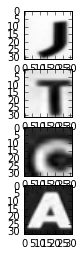

In [23]:
# Visualizing test 
# Take 10, 20, 30, 40
pylab.figure(1)

pylab.subplot(4, 1, 1)
img = test1_x[90]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()

pylab.subplot(4, 1, 2)
img = test1_x[80]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()

pylab.subplot(4, 1, 3)
img = test1_x[110]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()

pylab.subplot(4, 1, 4)
img = test1_x[120]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()

pylab.show()

In [24]:
# Redo above steps
tester = np.zeros((4, 1, 32, 32))
tester[0, ...] = test1_x[110]
tester[1, ...] = test1_x[120]
tester[2, ...] = test1_x[90]
tester[3, ...] = test1_x[80]

In [25]:
tester = tester.astype('float32')

In [27]:
preder = net.predict(tester)

In [28]:
real_pred = classer(preder)
real_pred = map(str, real_pred)

In [29]:
letter_stream = ''.join(real_pred).lower()

In [30]:
print letter_stream

cajt


In [31]:
print 'Probable words are: ', ', '.join(correct(letter_stream))

Probable words are:  cart, capt, cat, cast, cant, catt
